https://okumuralab.org/~okumura/python/t_u_test.html はヒストグラムを使っている点が非常によろしくない。

In [1]:
using Random
using Distributions
using Plots
using HypothesisTests
using QuadGK
using Roots

distname(dist) = replace(string(dist), r"{[^}]*}"=>"")
distname(dist::InverseGamma) = "InverseGamma(α=$(shape(dist)), θ=$(scale(dist)))"

default(fmt=:png, legend=false, titlefontsize=10, plot_titlefontsize=10, size=(400, 200))

# approximate Mann-Whitney U-testではデフォルトでは連続性補正がかかっている。
# https://github.com/JuliaStats/HypothesisTests.jl/blob/master/src/mann_whitney.jl#L236-L249
my_pvalue(x::ApproximateMannWhitneyUTest; continuity_correction=true) =
    continuity_correction ? pvalue(x) : 2ccdf(Normal(), abs(x.mu)/x.sigma)

function win_rate_of_y_against_x(distx::UnivariateDistribution, disty::ContinuousUnivariateDistribution)
    f(y) = cdf(distx, y) * pdf(disty, y)
    quadgk(f, extrema(disty)...)[1]
end

function equalizing_handicap(distx::UnivariateDistribution, disty::ContinuousUnivariateDistribution; p=1/2)
    f(s) = win_rate_of_y_against_x(distx + s, disty) - p
    find_zero(f, 0.0)
end

function p_values(distx, m, disty, n; niters=10^6, continuity_correction=true,
        handicap_mean = mean(disty) - mean(distx),
        handicap_win_rate = equalizing_handicap(distx, disty),
    )
    pvalue_student_t = zeros(niters)
    pvalue_welch_t = zeros(niters)
    pvalue_mann_whitney_u_exact = zeros(niters)
    pvalue_mann_whitney_u_approximate = zeros(niters)
    nth = Threads.nthreads(:interactive) + Threads.nthreads(:default)
    tmpx = [zeros(m) for _ in 1:nth]
    tmpy = [zeros(n) for _ in 1:nth]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        datax = rand!(distx, tmpx[tid])
        datay = rand!(disty, tmpy[tid])
        datax .+= handicap_mean
        pvalue_student_t[i] = pvalue(EqualVarianceTTest(datax, datay))
        pvalue_welch_t[i] = pvalue(UnequalVarianceTTest(datax, datay))
        datax .-= handicap_mean
        datax .+= handicap_win_rate
        pvalue_mann_whitney_u_exact[i] = pvalue(ExactMannWhitneyUTest(datax, datay))
        pvalue_mann_whitney_u_approximate[i] = my_pvalue(ApproximateMannWhitneyUTest(datax, datay); continuity_correction)
    end
    (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate)
end
    
function hist_p_values(distx, m, disty, n; niters=10^6, bin=0:0.05:1.05, continuity_correction=true,
        handicap_mean = mean(disty) - mean(distx),
        handicap_win_rate = equalizing_handicap(distx, disty),
    )
    @time (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate) =
        p_values(distx, m, disty, n; niters, continuity_correction, handicap_mean, handicap_win_rate)
    P1 = histogram(pvalue_student_t; norm=true, c=1, alpha=0.5, title="Student t-test", bin)
    P2 = histogram(pvalue_welch_t; norm=true, c=2, alpha=0.5, title="Welch t-test", bin)
    P3 = histogram(pvalue_mann_whitney_u_exact; norm=true, c=3, alpha=0.5, title="exact Mann-Whitney U-test", bin)
    P4 = histogram(pvalue_mann_whitney_u_approximate; norm=true, c=4, alpha=0.5, title="approximate Mann-Whitney U-test", bin)
    plot(P1, P2, P3, P4; size=(640, 400), layout=(2, 2))
    plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function ecdf_p_values(distx, m, disty, n; niters=10^6, maxalpha=1, continuity_correction=true,
        handicap_mean = mean(disty) - mean(distx),
        handicap_win_rate = equalizing_handicap(distx, disty),
    )
    @time (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate) =
        p_values(distx, m, disty, n; niters, continuity_correction, handicap_mean, handicap_win_rate)
    P1 = plot(x -> _ecdf(pvalue_student_t, x), 0, maxalpha; c=1, title="Student t-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P2 = plot(x -> _ecdf(pvalue_welch_t, x), 0, maxalpha; c=2, title="Welch t-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P3 = plot(x -> _ecdf(pvalue_mann_whitney_u_exact, x), 0, maxalpha; c=3, title="exact Mann-Whitney U-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P4 = plot(x -> _ecdf(pvalue_mann_whitney_u_approximate, x), 0, maxalpha; c=4, title="approximate Mann-Whitney U-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    plot(P1, P2, P3, P4; size=(640, 640), layout=(2, 2))
    plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")
end

ecdf_p_values (generic function with 1 method)

## P値の経験分布のヒストグラム

  1.914071 seconds (77.67 M allocations: 4.599 GiB, 25.80% gc time, 449.50% compilation time)


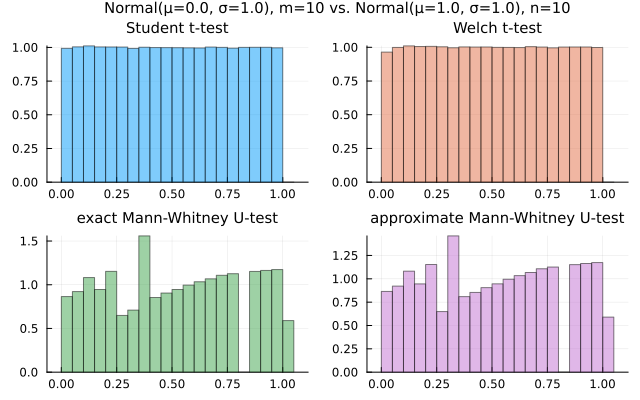

In [2]:
hist_p_values(Normal(), 10, Normal(1), 10)

  1.114918 seconds (73.98 M allocations: 4.459 GiB, 27.28% gc time)


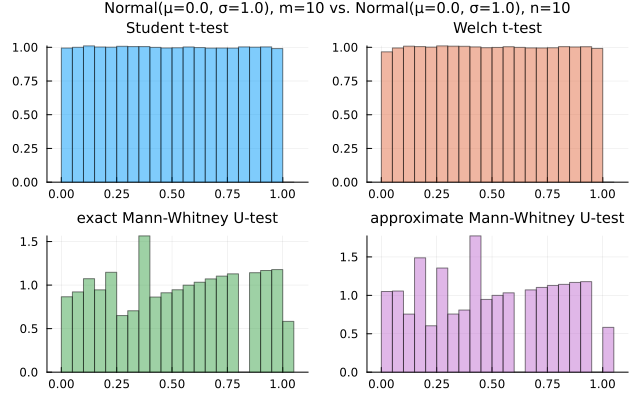

In [3]:
hist_p_values(Normal(), 10, Normal(), 10; continuity_correction=false)

  1.402645 seconds (73.96 M allocations: 4.457 GiB, 34.86% gc time)


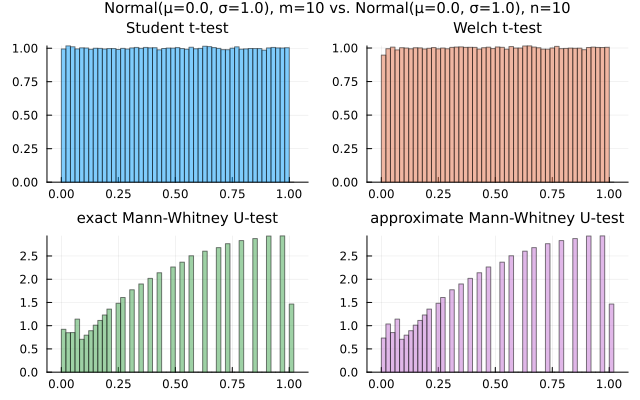

In [4]:
hist_p_values(Normal(), 10, Normal(), 10; bin=0:0.02:1.02)

  1.130408 seconds (73.96 M allocations: 4.458 GiB, 25.71% gc time)


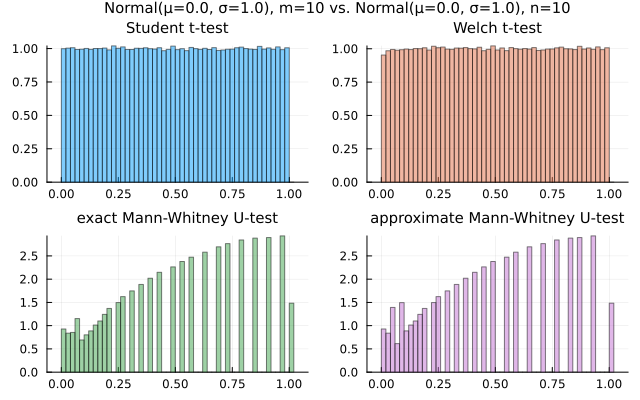

In [5]:
hist_p_values(Normal(), 10, Normal(), 10; bin=0:0.02:1.02, continuity_correction=false)

  1.243676 seconds (65.27 M allocations: 4.190 GiB, 33.17% gc time, 80.94% compilation time)


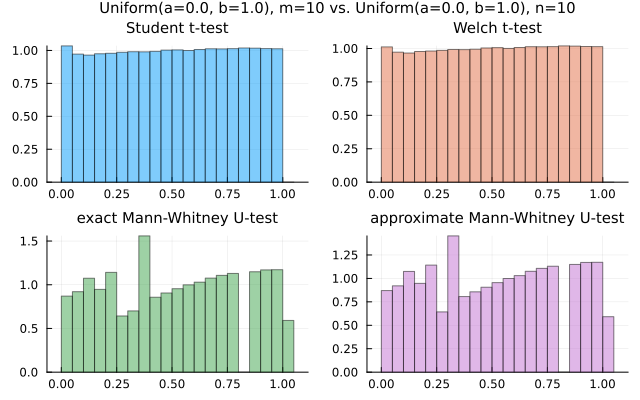

In [6]:
hist_p_values(Uniform(), 10, Uniform(), 10)

  1.071487 seconds (65.01 M allocations: 4.178 GiB, 26.46% gc time)


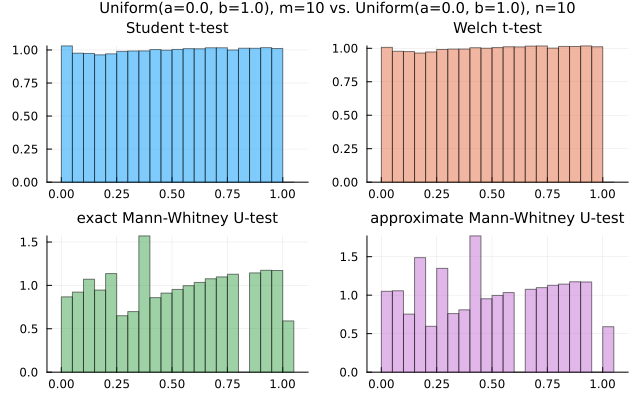

In [7]:
hist_p_values(Uniform(), 10, Uniform(), 10; continuity_correction=false)

  1.243206 seconds (65.01 M allocations: 4.177 GiB, 35.44% gc time)


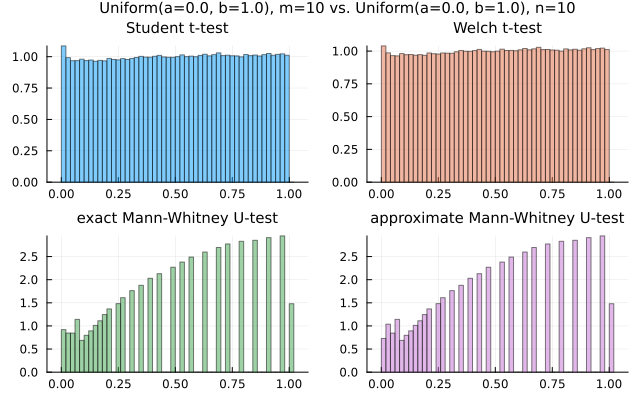

In [8]:
hist_p_values(Uniform(), 10, Uniform(), 10; bin=0:0.02:1.02)

  1.026575 seconds (65.02 M allocations: 4.178 GiB, 26.58% gc time)


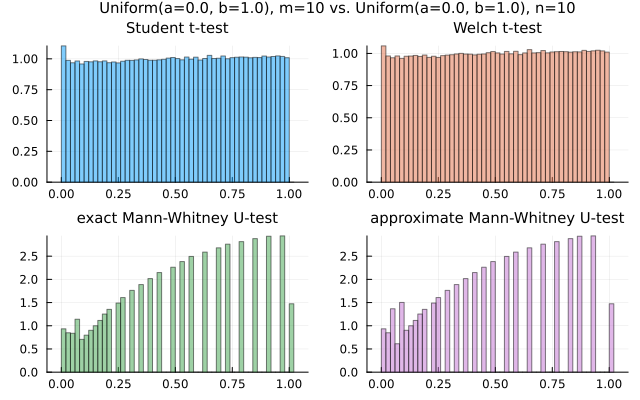

In [9]:
hist_p_values(Uniform(), 10, Uniform(), 10; bin=0:0.02:1.02, continuity_correction=false)

skewness(dist) = 41.952353926806026


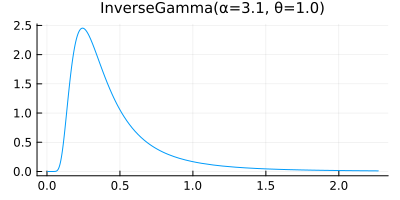

In [10]:
dist = InverseGamma(3.1, 1)
@show skewness(dist)
plot(x -> pdf(dist, x), 0, 5std(dist); title=distname(dist))

  1.214892 seconds (63.90 M allocations: 4.204 GiB, 32.65% gc time, 77.12% compilation time)


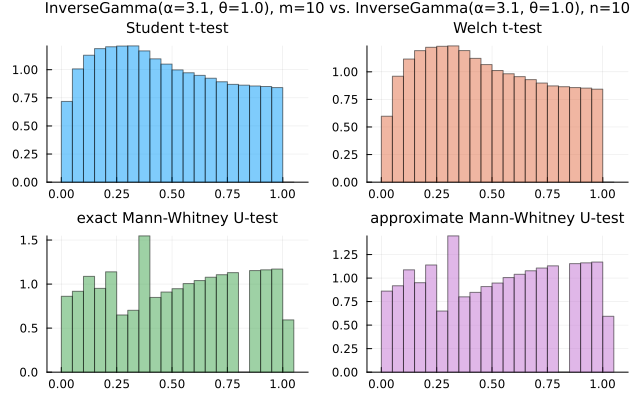

In [11]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10)

  1.037370 seconds (63.66 M allocations: 4.193 GiB, 25.89% gc time)


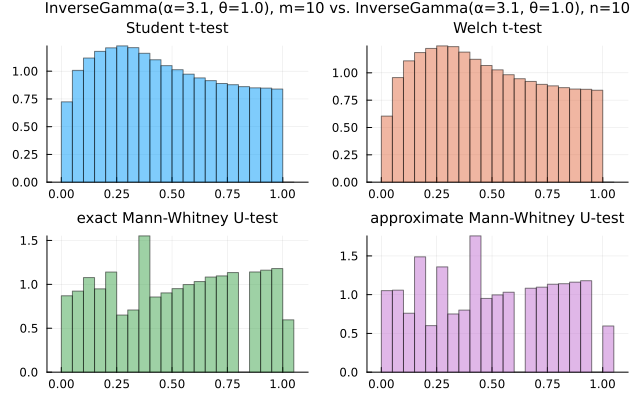

In [12]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; continuity_correction=false)

  1.258044 seconds (63.63 M allocations: 4.191 GiB, 35.82% gc time)


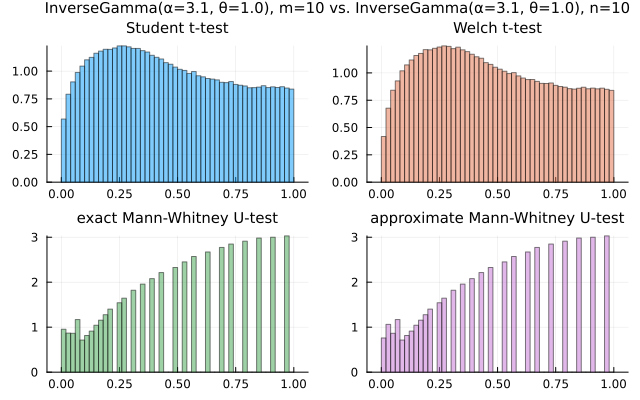

In [13]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; bin=0:0.02:1)

  1.094454 seconds (63.64 M allocations: 4.191 GiB, 26.61% gc time)


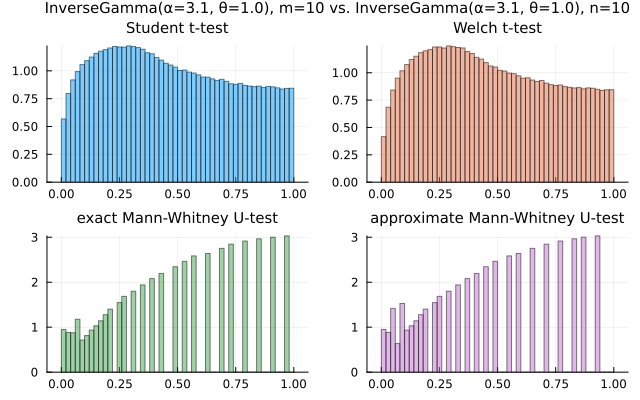

In [14]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; bin=0:0.02:1, continuity_correction=false)

## P値の経験累積分布関数のグラフ

  1.462562 seconds (73.95 M allocations: 4.456 GiB, 31.22% gc time)


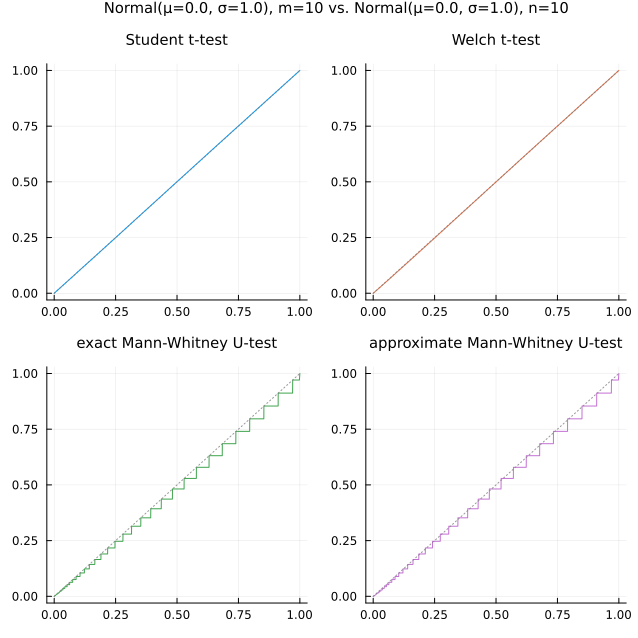

In [15]:
ecdf_p_values(Normal(), 10, Normal(), 10)

  1.179966 seconds (73.94 M allocations: 4.455 GiB, 27.30% gc time)


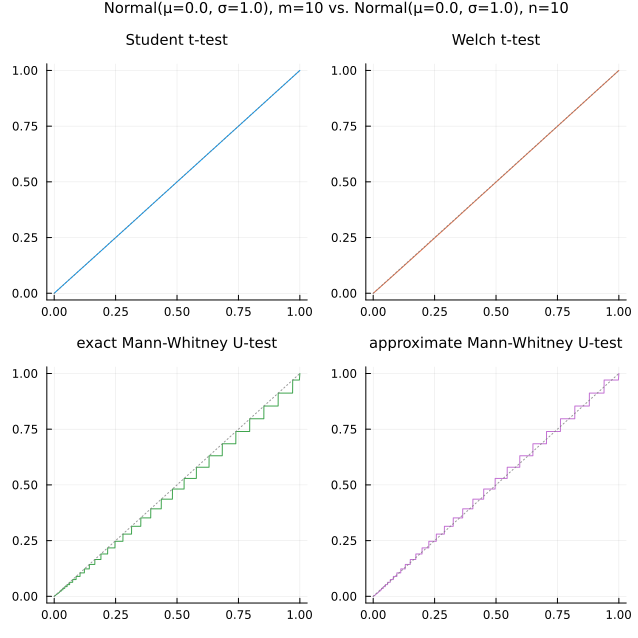

In [16]:
ecdf_p_values(Normal(), 10, Normal(), 10; continuity_correction=false)

  1.240396 seconds (65.02 M allocations: 4.179 GiB, 36.16% gc time)


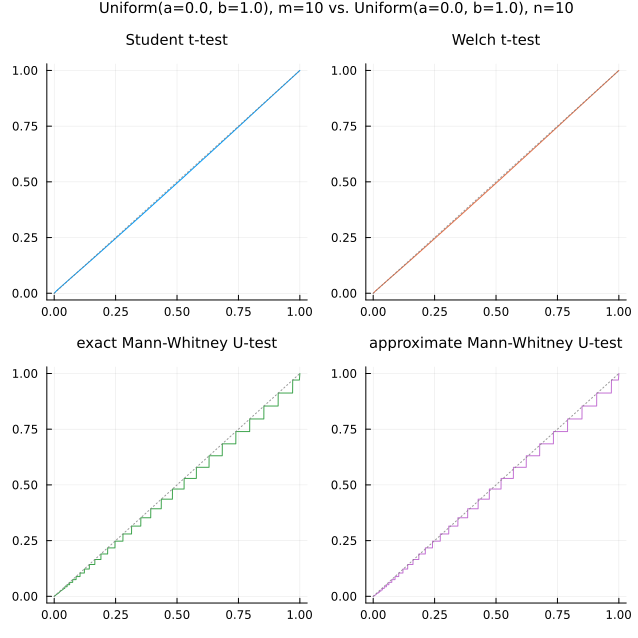

In [17]:
ecdf_p_values(Uniform(), 10, Uniform(), 10)

  1.055544 seconds (65.04 M allocations: 4.181 GiB, 25.73% gc time)


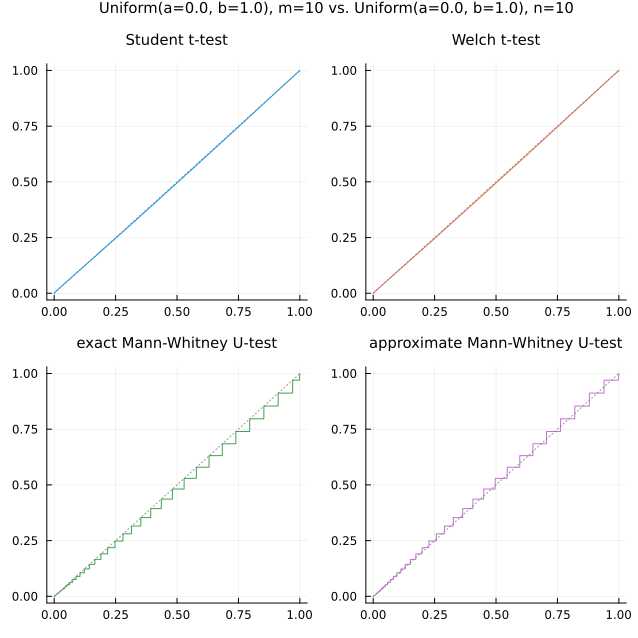

In [18]:
ecdf_p_values(Uniform(), 10, Uniform(), 10; continuity_correction=false)

skewness(dist) = 41.952353926806026


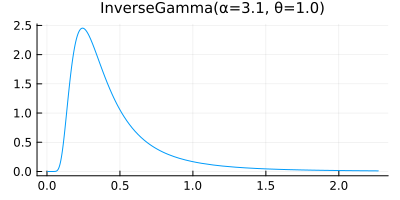

In [19]:
dist = InverseGamma(3.1, 1)
@show skewness(dist)
plot(x -> pdf(dist, x), 0, 5std(dist); title=distname(dist))

  1.287558 seconds (63.66 M allocations: 4.194 GiB, 36.80% gc time)


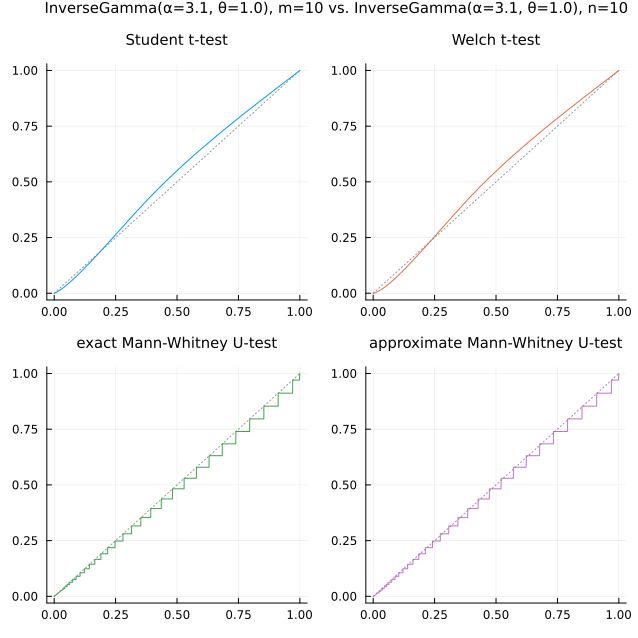

In [20]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10)

  1.069822 seconds (63.66 M allocations: 4.193 GiB, 26.42% gc time)


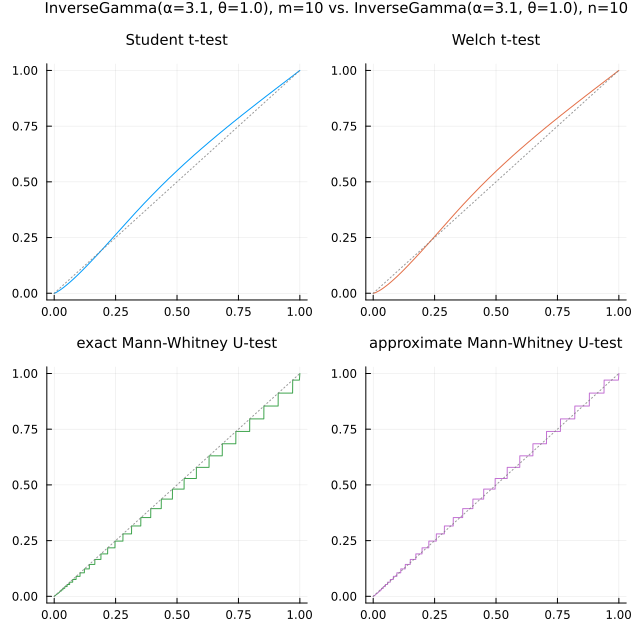

In [21]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; continuity_correction=false)

  1.260130 seconds (63.66 M allocations: 4.193 GiB, 34.52% gc time)


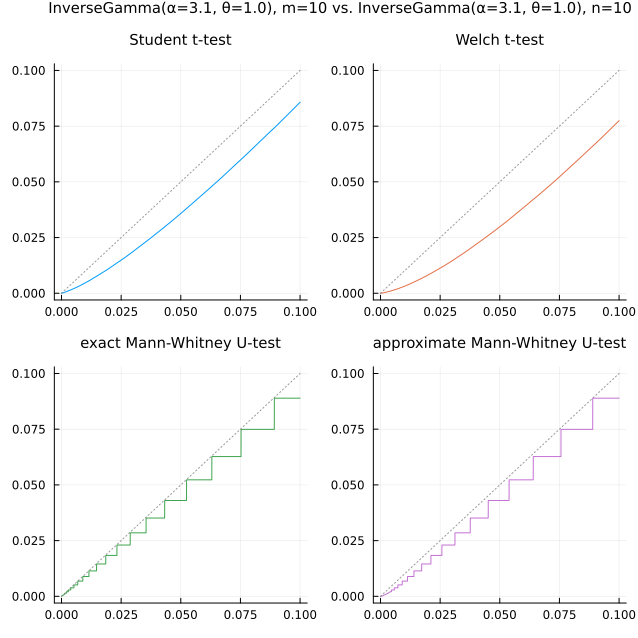

In [22]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; maxalpha=0.1)

  1.082345 seconds (63.64 M allocations: 4.191 GiB, 25.98% gc time)


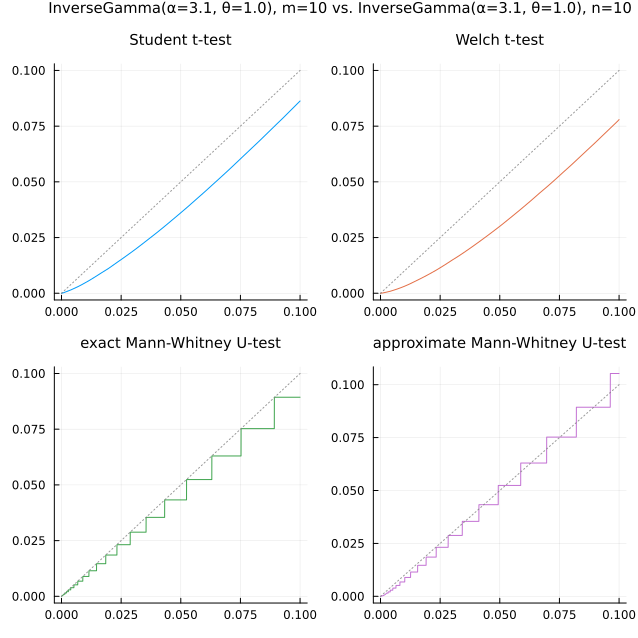

In [23]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; maxalpha=0.1, continuity_correction=false)

  0.862444 seconds (59.65 M allocations: 2.676 GiB, 38.77% gc time)


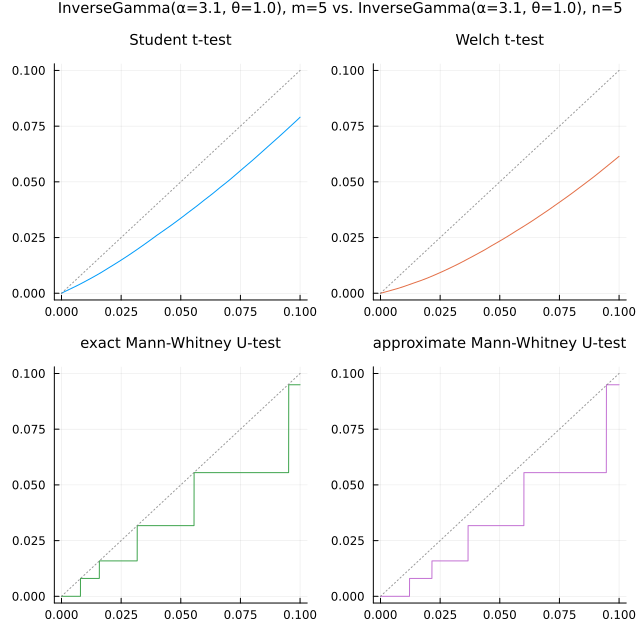

In [24]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 5; maxalpha=0.1)

  0.676402 seconds (59.66 M allocations: 2.676 GiB, 24.12% gc time)


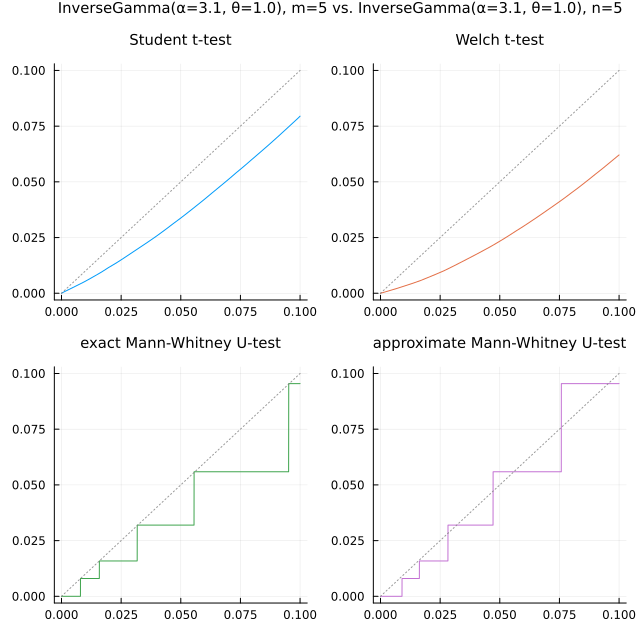

In [25]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 5; maxalpha=0.1, continuity_correction=false)

  1.036857 seconds (63.63 M allocations: 3.414 GiB, 37.73% gc time)


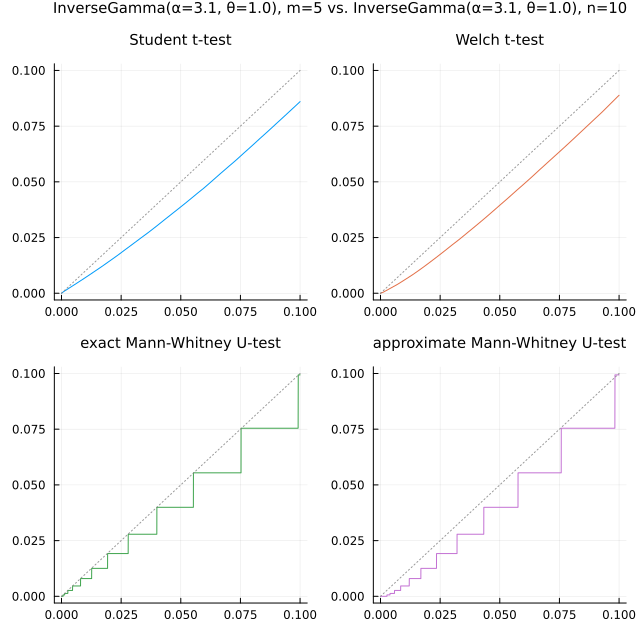

In [26]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 10; maxalpha=0.1)

  0.809693 seconds (63.62 M allocations: 3.413 GiB, 25.46% gc time)


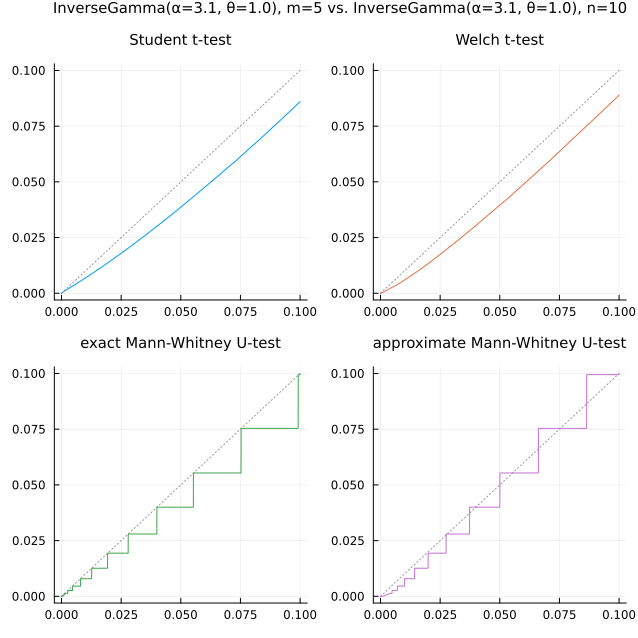

In [27]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 10; maxalpha=0.1, continuity_correction=false)

  1.325813 seconds (68.11 M allocations: 4.941 GiB, 33.17% gc time)


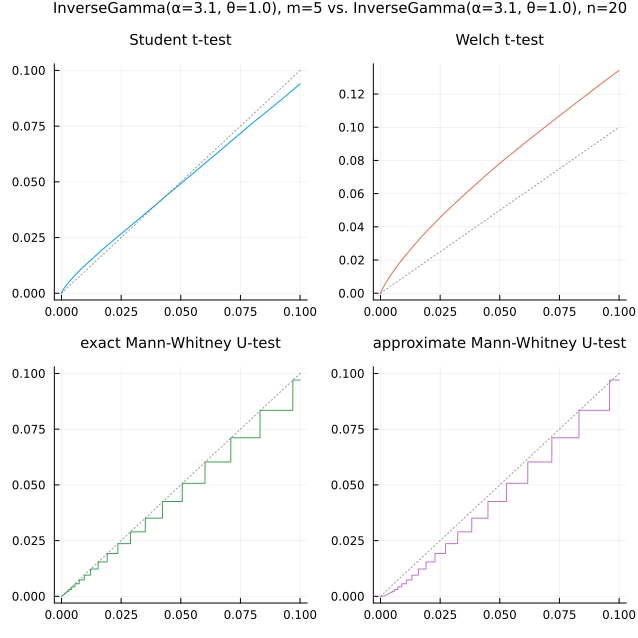

In [28]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 20; maxalpha=0.1)

  1.139772 seconds (68.12 M allocations: 4.943 GiB, 24.03% gc time)


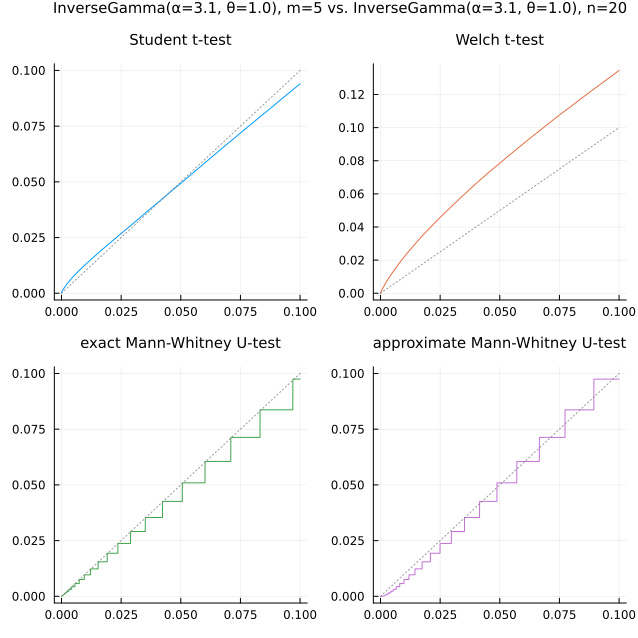

In [29]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 20; maxalpha=0.1, continuity_correction=false)